# Superoperator Formalism

Here, I present a way to represent the effect of a pulse as a matrix, massively speeding up computation, and allowing more detailed error analysis.

We start with a recounting of the basics, considering a single $n$-level qubit. A pure state (ket) of this qubit $\ket{\psi}$ exists in an $n$-dimensional Hilbert space, and is represented by a vector of length $n$. An operator is a map from $\mathcal{H}_n\to\mathcal{H}_n$, and is a map from kets to other kets.

If we now include mixed states, allowing for non-unitary evolution, we must change formalism. Now, a state is represented by a *density operator* $\rho=\ket{\psi}\bra{\psi}$, which is represented as an $n\times n$ matrix. This is why they are also known as *density matrices*.

> It can be seen that some of the operators in the pure formalism can be seen as density matrices representing states. For example, the $X90$ operator corresponds to the state $\ket{0}+\ket{1}$.

The question is then how do we operate on these density matrices? A naïve way would be to simply change the way they operate:

$$A\ket{\psi}\to A\rho A^\dag$$

However, this does not offer much insight into the process. A better way is to use a representation known as a Pauli Transfer Matrix.

## PTMs

> Go over this - in particular, why have the dimensions changed, and why is it a 4x4 matrix?

Consider a linear map $\rho \to \Lambda(\rho)$, acting on a Hilbert space which has some basis $P$. In 2D, this can be the Pauli set. For higher dimensions, we use the `generate_basis` function from `helpers.py`.

Then, we have a change of dimension: density matrices, which were $n\times n$ matrices, become vectors of length $n^2$ on a Hilbert space $\mathcal{H}_{n^2}$, and are written as superkets $\ket{\rho}\rangle$. Operators become superoperators, and are represented by matrices of dimension $n^2\times n^2$.

Under this formalism, we can derive something called the Pauli Transfer Matrix:

$$\left(R_\Lambda\right)_{ij}=\frac{1}{n}\text{Tr }\left[P_i\Lambda\left(P_j\right)\right]$$

And we find that

$$\ket{\Lambda(\rho)}\rangle=R_\Lambda \ket{\rho}\rangle$$

That is, the superket after the map is found by multiplying the PTM by the superket before the map. This means if we can find the PTM for a given map (by finding the result of its application to the basis vectors) then we can find the result of the operation for *any* initial state.

The question is now how to transfer from density matrices and operators to superkets and superoperators. We use a decomposition method to *vectorise* the matrices.

That is, the superket is a *vector* of length $n^2$ which has elements

$$\ket{\rho}\rangle_i=\langle\braket{k|\rho}\rangle=\text{Tr }P_k\rho$$

Where $k\equiv P_k$. That is, decompose the matrix $\rho$ into the basis $P$, and then the superket represents these coefficients.

For example,

$$\ket{\rho}\rangle=\begin{pmatrix}0.5\\0\\0.2\\0.3\end{pmatrix}\implies \rho =0.5P_0+0P_1+0.2P_2+0.3P_3$$

### Key Properties

The PTM has a number of key properties which make it useful.

 - The elements satisfy $(R_\Lambda)_{ij}\in\mathbb{R}, (R_\Lambda)_{ij}\in[-1, 1]$
 - The PTM of some composite map is equal to the product of the individual PTMs, which makes simulating a circuit easy

Then, all maps $\Lambda$ must be CPTP (completely positive (positive probabilities) and trace-preserving (probabilities add to 1)). This puts two requirements on $R_\Lambda$:

$$\left(R_\Lambda\right)_{0j}=\delta_{0j}=(1,0,0,\dots,0)$$

The second requirement is that we require $\rho_\Lambda$ to be positive semi-definite, where

$$\rho_\Lambda=\frac{1}{d^2}\sum_{i,j=1}^{d^2}{(R_\Lambda)_{ij}P_j^T\otimes P_i}$$

The map may also be unital, which means that it maps the identity to the identity, or equivalently, it does not make a state more pure. This can be visualised as the requirement that the zero vector on the Bloch sphere (maximally mixed state) is not mapped to a nonzero vector (less mixed state). If the map is unital, we find that the first *column* of $R_\Lambda$ satisfies

$$R_{i0}=\delta_{i0}=\begin{pmatrix}1\\0\\0\\\vdots\\0\end{pmatrix}$$

## Errors

does error analysis require me to change from a PTM to a process matrix?

## Algorithm

The algorithm I will use is as follows

1. Set up a transmon with some defined parameters
2. Using pulse-level simulation, find the optimal pulse parameters to execute an X90 pulse. Initially start with $\ket{0}$, but once the pulse is near-optimal, simulate a random starting state
3. Calculate the PTM by running the pulse on all of the basis states
4. Verify the PTM by comparing the simulated and pulse-level result for some initial state
5. Analyse the PTM to correlate error sources and types?

Discuss this plan with Peter.

## Notes

The inner product of two vectors or matrices is defined as

$$\braket{A|B}\text{ or }\langle\braket{A|B}\rangle = \text{Tr } A^\dag B$$

And the expected value of any operator is

$$\braket{E}=\text{Tr }E\rho$$

In [1]:
from qutip import *
from qutip_qip import circuit, operations
import numpy as np
# from helpers import *
from transmon import *
from simulate import *
from scipy.linalg import logm

In [2]:
# define initial variables
d = 8

# pauli basis
P = [identity(2), sigmax(), sigmay(), sigmaz()]
P = [i/np.sqrt(d) for i in P]

# OR a basis generated by generate_basis
P = [Qobj(i) for i in generate_basis(d)]

# OR a two-level basis but expanded
P = [expand(Qobj(i), d) for i in generate_basis(2)]

# OR a d-level basis but reduced

# P_reduced = []
# 
# for i, m in enumerate(P):
#     tmp = [i[:2] for i in m.full()[:2]]
# 
#     if all([abs(i)==0 for j in tmp for i in j]):
#         P_reduced.append(Qobj(np.zeros(m.shape)))
#     else:
#         P_reduced.append(m)
# 
# P = P_reduced

In [3]:
# simulate the expected result
def run_circuit(initial_state, gate="X90"):
    g = expand(U(gate_angles[gate]), initial_state.dims[0][0])
    if initial_state.isket:
        return g*initial_state
    else:
        return g*initial_state*g.dag()

# here is the pulse simulation
tr = Transmon(n_levels=8, initial_state=0, Ω=5000, α=-100, RWA=True, dt=1/1000)
tr.X90_args = {'A': 7.449877548484732, 'Γ': 0.5024320350942441, 'ω': 5000.0, 'A_DRAG': -0.0034947574297965116}

def run_pulse(initial_state):

    tr.ψ0 = initial_state
    results = simulate(tr, tr.X90_args)
    return results[-1]

In [ ]:
# calculate the observed PTM using Λ(P) for each P in the basis
PTM = Qobj([[np.trace(i.dag()*run_pulse(j)) for j in P] for i in P])
disp(PTM)

In [7]:
# define the helpers for simulating the circuit on a general state

def to_vec(ρ):
    return Qobj([[np.trace(truncate(i)*ρ) for i in P]]).trans() #to convert to column

def to_oper(vec):
    return sum([vec.full()[i][0] * P[i] for i in range(vec.dims[0][0])])

def apply_PTM(state, PTM):
    if state.isket:
        state = ket2dm(state)

    return to_oper(PTM*to_vec(state))

def run_Zθ(init, θ):
    d = init.dims[0][0]
    init = truncate(init)
    qc = circuit.QubitCircuit(1)
    qc.add_gate("RZ", targets=0, arg_value=θ)
    return expand(qc.run(init), d)

def PTM_for_Zθ(θ):

    return Qobj([[np.trace(i.dag()*run_Zθ(j, θ)) for j in P] for i in P])

# calculate the ideal PTM
def ideal_PTM(gate):
    return Qobj([[np.trace(i.dag()*run_circuit(j, gate)) for j in P] for i in P])

In [8]:
init = (basis(2,0)+1j*basis(2,1)).unit()

# predicted result using PTM
predicted = apply_PTM(init, PTM)
# actual result from pulse
actual = ket2dm(run_circuit(init))

disp(truncate(predicted))
disp(actual)

plot_bloch([truncate(actual)])

NameError: name 'PTM' is not defined

In [14]:
g = "Y45"

Y45_PTM = ideal_PTM(g)
X90_PTM = ideal_PTM("X90")

θ, φ, λ, _ = decompose_gate(U(gate_angles[g]))

decomposed_PTM = PTM_for_Zθ(φ-np.pi/2) * X90_PTM * PTM_for_Zθ(np.pi-θ) * X90_PTM * PTM_for_Zθ(λ-np.pi/2)

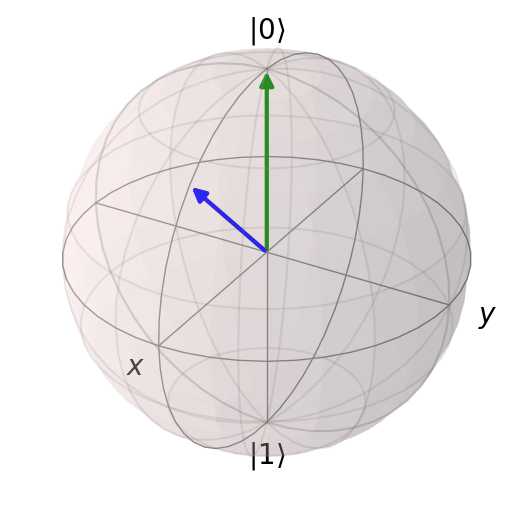

In [15]:
init = basis(2,0)

way_1 = truncate(apply_PTM(init, Y45_PTM))
way_2 = truncate(apply_PTM(init, decomposed_PTM))
# step_X_Z90 = truncate(apply_PTM(step_X90, Z90))
plot_bloch([init, way_1, way_2])

In [ ]:
error_gate = PTM * PTM_ideal.inv()
np.eye(error_gate.dims[0][0]) - error_gate

In [ ]:
PTM.norm()